# Simulation of Exome-wide CNV data for case control samples

## Simulation outline
For given type of CNV (e.g. duplication) we first simulate all the variants across exome, 
then assign these simulated CNVs to genes. For case samples we expect an enrichment in causal
genes and the enrichment should be quantified by relative risk of a CNV's contribution to disease
when presented in causal gene vs. non causal gene.

## Parameters
We define causal CNV as CNV in causal gene, and denote it as CCNV. Likewise we have NCNV for non-causal CNV.

| Parameter | Description | Value|
|:-----:|:-----:|:-----:|
|$\lambda$|Average number of CNV per exome| 100 for dup, 20 for del (*FIXME: reference required*)|
|$p_L$|Parameter for Geometric distribution that models length of CNV|To be fitted from data|
|$\gamma$| Odds ratio of CCNV|To draw from distribution Gamma(5, 1)|
|$p_0$| Pr(case &#124; NCNV)| It can be approximated by $k$ = Pr(case) |
|$p_1$| Pr(case &#124; CCNV)| To be calculated from $p_0$ and $\gamma$|
|$N_0, N_1$| Case / Ctrl sample size|Various numbers|
|$k$| The prevalence of disease|(*FIXME: reference required*)|

## Simulation steps
The steps below simulates exome data for single individual case or control for one type of CNV. 

### Step 1: Simulate number of CNV per exome
Simply drawn from $M = Pois(\lambda)$

### Step 2: Simulate CNV for an exome
#### Positions of CNVs
Distribution of CNV in exome is non-uniform. We need to obtain empirical distribution for CNV hotspots and simulate CNV positions to reflect the hotspot pattern. 

First, separate genome to 100K blocks and find from real data how many CNVs falls in each block (start position is in a block). We can visualize this via histogram. This gives the pattern of CNV hotspots in exome.

Then sample with replacement $M$ such blocks from all blocks based on frequency of their apparences (weighted uniform sample).

Finally for each block sampled we put a CNV start position in it, uniformly. Now we need the length of CNV to determine the end positions.

#### Length of CNVs

We can mimic the distribution of the length of CNV. There are 3 ways to do it:

1. Fit a **mixture** of geometric/gamma/gaussian using real data: mixing long tail, short tail and normal tail distributions.
2. Fit a geometric distribution
3. Instead of fitting anything we simply draw $M$ CNV from real data.

Here we adopt option 3. We have tried option 1 and 2 but the result is not good.

### Step 3: Tag each simulated CNV by causal genes
Causal/noncausal gene positions are supposed to be determined by literature. But we can simulate randomly for starters. Today (2017/02) as a first simple pass we call every CNV within the following 100 genes as causal CNV and non-causal elsewhere:

In [ ]:
causal_genes_del = ['RAB2B', 'CHD8', 'TOX4', 'SNORD8', 'METTL3', 'SALL2', 'SNORD9', 'SUPT16H', 'RPGRIP1', 'MIR3180-3', 'MIR3670-1', 'NOMO2', 'MIR6511A4', 'NPIPA8', 'FSIP2', 'FSIP2-AS1', 'LOC101927196', 'ATP6V1E1', 'BCL2L13', 'BID', 'CECR1', 'CECR2', 'CECR3', 'CECR5', 'CECR5-AS1', 'CECR6', 'CECR7', 'FLJ41941', 'GAB4', 'IL17RA', 'LINC00528', 'LOC100996342', 'LOC100996415', 'LOC101929372', 'LOC105379550', 'MICAL3', 'MIR3198-1', 'MIR648', 'PEX26', 'SLC25A18', 'TUBA8', 'USP18', 'FAM72C', 'FAM72D', 'LINC01138', 'NBPF8', 'PPIAL4G', 'MIR6770-2', 'MIR3179-1', 'MIR3180-2', 'MACROD2', 'FAM189A1', 'LOC100130111', 'MACROD2-AS1', 'LINC00623', 'LINC00869', 'PPIAL4C', 'MIR3680-2', 'ABCC6P1', 'HNRNPC', 'APBA2', 'C22orf39', 'CDC45', 'CLDN5', 'CLTCL1', 'DGCR14', 'DGCR2', 'GNB1L', 'GOLGA6L7P', 'GOLGA8M', 'GP1BB', 'GSC2', 'HIRA', 'LINC00895', 'LINC01311', 'LOC100289656', 'MRPL40', 'NPIPB4', 'NSMCE3', 'PDCD6IPP2', 'SEPT5', 'SEPT5-GP1BB', 'SLC25A1', 'TBX1', 'TSSK2', 'UFD1L', 'WHAMMP2', 'HSFY1P1', 'PFN1P2', 'XKR3', 'OR4A47', 'C5orf17', 'CNTN4', 'EXOC4', 'LINC00540', 'LOC101927967', 'LRRC4C', 'SMG1P2', 'SPRY2', 'LOC100288162']
causal_genes_dup = ['CHN2', 'ESYT2', 'KIF26B', 'RPGRIP1', 'C22orf39', 'CDAN1', 'CDC45', 'CLDN5', 'GNB1L', 'GP1BB', 'HIRA', 'LINC00895', 'MRPL40', 'SEPT5', 'SEPT5-GP1BB', 'STARD9', 'TBX1', 'TTBK2', 'UFD1L', 'LOC283177', 'AGAP6', 'COL18A1', 'COL18A1-AS1', 'FAM21EP', 'LOC440910', 'MIR6815', 'POTEE', 'SLC19A1', 'TIMM23B', 'VAV2', 'WASHC2A', 'PTPRN2', 'ANO2', 'CCNDBP1', 'COLEC12', 'EPB42', 'FAM118A', 'FAM160A1', 'FBLN1', 'KIAA0930', 'LINC01589', 'LOC100996325', 'LOC728613', 'LRRIQ3', 'MACROD2', 'MIR1249', 'NUP153', 'NUP50', 'NUP50-AS1', 'PRSS48', 'RAP1GAP2', 'RBM47', 'RIBC2', 'SH3D19', 'SMC1B', 'TGM5', 'TMEM62', 'UPK3A', 'VWF', 'DGKH', 'KIF13A', 'LINC01266', 'VWA8', 'VWA8-AS1', 'CRYM-AS1', 'SNX29P1', 'KCNJ12', 'KCNJ18', 'BNC1', 'LOC105375545', 'MIR128-2', 'AGAP7P', 'BTBD11', 'C3orf67', 'CHD8', 'COL18A1-AS2', 'FAM110C', 'GMDS', 'HIRIP3', 'INO80E', 'LINC01022', 'MARK3', 'MIR5707', 'MSMB', 'NCAPG2', 'NCOA4', 'PAK5', 'PLEKHB2', 'PWP1', 'RAB2B', 'RNF103-CHMP3', 'SNORD8', 'SNORD9', 'SUPT16H', 'TIMM23', 'ZCCHC14', 'C17orf51', 'COX20', 'DLG1', 'EFCAB2']

This list of genes are the top genes from [enrichment analysis](enrichment_analysis_of_CNV_in_schizophrenia.html).

### Step 4: Get the probability of a sample being case give all genes
Suppose $p$ is baseline probability of the disease (prevalence), and $r_0$ is the baseline odds $\frac{p}{1-p}$.

Given all the genes which overlap with simulated CNVs in a sample, the probability for the sample to be case is $p_1$, then the odds ratio for case is $r_1 = r_0 \times R = \frac{p_1}{1-p_1}$, $R$ is the combined relative risks of the genes overlapped with CNVs in a sample. Each $R_i$ for a causal gene is to be sampled from Gamma(5,1), $R = \prod_{i=1}^{\#gene} R_i$. For noncausal gene, $R_i$ is 1. Then $P(case|all\ CNVs) = p_1 = \frac{r_0*R}{1+r_0*R}$, and $P(ctrl|all\ CNVs) = 1-p_1$.

Since $p_1$ is small, about $\frac{1}{p} * n$ trials are to be simulated in order to obtain $n$ cases. However, $n$ controls are easy to obtain.

## Implementation

In [1]:
import random
from random import randint
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import math
from sklearn.mixture import GaussianMixture
from datetime import datetime
import pickle
from fisher import pvalue

%matplotlib inline


def load_reference_gene(filename):
    '''Load reference gene database'''
    ref_gene = pd.read_table(filename, compression="gzip", sep="\t", 
                         header = None, usecols=(1,2,4,5,12), 
                         names = ["tx_name", "chrom", "tx_start", "tx_end", "gene_name"])
    return ref_gene.drop_duplicates(subset=("chrom", "tx_start", "tx_end"))

def load_cnv_data(filename):
    '''load cnv data'''
    cnvbed = {}
    dataset = None
    for line in open(filename).readlines():
        if not line.startswith("chr"):
            dataset = line.strip().split()[1].lstrip("name=")
            cnvbed[dataset] = {}
            continue
        line = line.strip().split()
        if not line[0] in cnvbed[dataset]:
            cnvbed[dataset][line[0]] = []
        cnvbed[dataset][line[0]].append((int(line[1]),int(line[2])))

    for dataset in cnvbed.keys():
        for chrom in cnvbed[dataset]:
            cnvbed[dataset][chrom].sort()

    cnvbed_df = {}
    for dataset in cnvbed.keys():
        cnvbed_df[dataset] = {"chrom":[], "cnv_start":[], "cnv_end":[]}
        for chrom in cnvbed[dataset]:
            start, end = tuple(zip(*cnvbed[dataset][chrom])) 
            cnvbed_df[dataset]["chrom"].extend([chrom] * len(start))
            cnvbed_df[dataset]["cnv_start"] += list(start)
            cnvbed_df[dataset]["cnv_end"] += list(end)
        cnvbed_df[dataset] = pd.DataFrame.from_dict(cnvbed_df[dataset]).drop_duplicates(
                                                subset=("chrom", "cnv_start", "cnv_end"))
    return cnvbed_df

def count_cnv_by_block(df, block_size):
    # check how many CNVs start in block_size = 100K blocks genome
    # this cell produces `block_counts`: ((chrom, block_position), count)
    def count_by_blocks(chrom):
        data = df.query('chrom == "{}"'.format(chrom))['cnv_start'].tolist()
        start_pos = min(data)
        end_pos = max(data)
        counts, bins = np.histogram(data, bins = int((end_pos - start_pos) / block_size) + 1, 
                                    range = (start_pos, end_pos))
        return counts, [int(x) for x in bins]
    block_counts = []
    for chrom in set(df['chrom']):
        counts, bins = count_by_blocks(chrom)
        # most blocks contain 0 CNV start. Add 0.5 to each block, so that CNV could start within any block.
        block_counts.extend([((chrom, x), y+0.5) for x, y in zip(bins, counts)])
    return block_counts

def fit_truncated_gaussian_mix(x, k = 10):
    x = x.extend([-i for i in x])
    clf = GaussianMixture(n_components=1, covariance_type='full')
    clf.fit(x)
    return clf

def sample_cnv_length(data, mean_num_cnv):
    return np.random.choice(data, np.random.poisson(mean_num_cnv))

def get_sample_blocks(block_counts, num_cnv):
    '''sample blocks from blocks across genome'''
    probability_distribution = np.array([x[1] for x in block_counts])
    sample_idx = np.random.choice(range(len(block_counts)), num_cnv, 
                                  p = probability_distribution / sum(probability_distribution))
    return sorted([block_counts[idx][0] for idx in sample_idx])

def assign_cnv_to_sample(sample_blocks, sample_len, block_size):
    samples = {'chrom': [], 'cnv_start': [], 'cnv_terminate': []}
    for x, y in zip(sample_blocks, sample_len):
        start_pos = randint(x[1], x[1] + block_size)
        samples['cnv_start'].append(start_pos)
        samples['cnv_terminate'].append(start_pos + int(y))
        samples['chrom'].append(x[0])
    return pd.DataFrame(samples)

def annotate_samples(samples, gene_df):
    query = """
        SELECT cnv.chrom, cnv.cnv_start, cnv.cnv_terminate, gene.tx_name, gene.gene_name
        FROM samples cnv LEFT JOIN gene_df gene
        WHERE cnv.chrom == gene.chrom 
        AND (
        (cnv.cnv_start >= gene.tx_start AND cnv.cnv_start <= gene.tx_end)
        OR
        (cnv.cnv_terminate >= gene.tx_start AND cnv.cnv_terminate <= gene.tx_end)
        OR
        (cnv.cnv_start <= gene.tx_start AND cnv.cnv_terminate >= gene.tx_end)
        )
        """
        # drop_duplicates(): make sure the case that CNV spread multiple txs but each gene to be counted only once
    return sqldf(query).drop_duplicates(subset=("chrom", "cnv_start", "cnv_terminate", "gene_name"))

def get_causal_genes(causal_genes, sample_genes):
    '''get causal genes for each simulated sample'''
    return [x for x in causal_genes if x in sample_genes]

def get_ccnv():
    '''get causal cnvs'''
    return None
    
def p_case(p, num_causal_genes_in_sample, sim_args):
    if num_causal_genes_in_sample == 0:
        return p
    baseline_odds = p / (1 - p)
    odds_ratio = np.prod([np.random.gamma(sim_args["odds_ratio_params"]['shape'], 
                                          sim_args["odds_ratio_params"]['scale']) 
                          for x in range(num_causal_genes_in_sample)])
    # obtain the power of fisher test by setting odds ratio to 1
    # odds_ratio = 1
    odds = baseline_odds * odds_ratio
    return odds / (1 + odds)

class Environment:
    def __init__(self):
        self.args = {'block_size': 100000,
                     'avg_cnv_per_individual': 5,
                     'n_case': 10,
                     'n_ctrl': 10,
                     # set Gamma shape to be 3 instead of 5
                     'odds_ratio_params': {'shape': 3, 'scale': 1},
                     'prevalence': 0.005
                    }
        
        self.causal_genes = {
            "causal_genes_del": ['RAB2B', 'CHD8', 'TOX4', 'SNORD8', 'METTL3', 'SALL2', 'SNORD9', 'SUPT16H', 
                                 'RPGRIP1', 'MIR3180-3', 'MIR3670-1', 'NOMO2', 'MIR6511A4', 'NPIPA8', 'FSIP2', 
                                 'FSIP2-AS1', 'LOC101927196', 'ATP6V1E1', 'BCL2L13', 'BID', 'CECR1', 'CECR2', 
                                 'CECR3', 'CECR5', 'CECR5-AS1', 'CECR6', 'CECR7', 'FLJ41941', 'GAB4', 'IL17RA', 
                                 'LINC00528', 'LOC100996342', 'LOC100996415', 'LOC101929372', 'LOC105379550', 
                                 'MICAL3', 'MIR3198-1', 'MIR648', 'PEX26', 'SLC25A18', 'TUBA8', 'USP18', 'FAM72C', 
                                 'FAM72D', 'LINC01138', 'NBPF8', 'PPIAL4G', 'MIR6770-2', 'MIR3179-1', 'MIR3180-2', 
                                 'MACROD2', 'FAM189A1', 'LOC100130111', 'MACROD2-AS1', 'LINC00623', 'LINC00869', 
                                 'PPIAL4C', 'MIR3680-2', 'ABCC6P1', 'HNRNPC', 'APBA2', 'C22orf39', 'CDC45', 'CLDN5',
                                 'CLTCL1', 'DGCR14', 'DGCR2', 'GNB1L', 'GOLGA6L7P', 'GOLGA8M', 'GP1BB', 'GSC2', 
                                 'HIRA', 'LINC00895', 'LINC01311', 'LOC100289656', 'MRPL40', 'NPIPB4', 'NSMCE3', 
                                 'PDCD6IPP2', 'SEPT5', 'SEPT5-GP1BB', 'SLC25A1', 'TBX1', 'TSSK2', 'UFD1L', 
                                 'WHAMMP2', 'HSFY1P1', 'PFN1P2', 'XKR3', 'OR4A47', 'C5orf17', 'CNTN4', 'EXOC4', 
                                 'LINC00540', 'LOC101927967', 'LRRC4C', 'SMG1P2', 'SPRY2', 'LOC100288162'],
            "causal_genes_dup": ['CHN2', 'ESYT2', 'KIF26B', 'RPGRIP1', 'C22orf39', 'CDAN1', 'CDC45', 'CLDN5', 
                                 'GNB1L', 'GP1BB', 'HIRA', 'LINC00895', 'MRPL40', 'SEPT5', 'SEPT5-GP1BB', 'STARD9', 
                                 'TBX1', 'TTBK2', 'UFD1L', 'LOC283177', 'AGAP6', 'COL18A1', 'COL18A1-AS1', 
                                 'FAM21EP', 'LOC440910', 'MIR6815', 'POTEE', 'SLC19A1', 'TIMM23B', 'VAV2', 
                                 'WASHC2A', 'PTPRN2', 'ANO2', 'CCNDBP1', 'COLEC12', 'EPB42', 'FAM118A', 'FAM160A1', 
                                 'FBLN1', 'KIAA0930', 'LINC01589', 'LOC100996325', 'LOC728613', 'LRRIQ3', 'MACROD2', 
                                 'MIR1249', 'NUP153', 'NUP50', 'NUP50-AS1', 'PRSS48', 'RAP1GAP2', 'RBM47', 'RIBC2', 
                                 'SH3D19', 'SMC1B', 'TGM5', 'TMEM62', 'UPK3A', 'VWF', 'DGKH', 'KIF13A', 'LINC01266', 
                                 'VWA8', 'VWA8-AS1', 'CRYM-AS1', 'SNX29P1', 'KCNJ12', 'KCNJ18', 'BNC1', 
                                 'LOC105375545', 'MIR128-2', 'AGAP7P', 'BTBD11', 'C3orf67', 'CHD8', 'COL18A1-AS2', 
                                 'FAM110C', 'GMDS', 'HIRIP3', 'INO80E', 'LINC01022', 'MARK3', 'MIR5707', 'MSMB', 
                                 'NCAPG2', 'NCOA4', 'PAK5', 'PLEKHB2', 'PWP1', 'RAB2B', 'RNF103-CHMP3', 'SNORD8', 
                                 'SNORD9', 'SUPT16H', 'TIMM23', 'ZCCHC14', 'C17orf51', 'COX20', 'DLG1', 'EFCAB2']
        }

    def print(self, do_not_print = False):
        if not do_not_print:
            print("Number of causal deletion genes {}".format(len(self.causal_genes)))
        self.a_new_one = 'hello'

env = Environment()
        
def simulate(refgene, cnv_data, args, causal_genes):
    df = cnv_data.drop_duplicates(subset=("chrom", "cnv_start", "cnv_end"))
    block_counts = count_cnv_by_block(df, args['block_size'])
    cnv_length = cnv_data['cnv_end'] - cnv_data['cnv_start']
    status = 1
    case_data = []
    ctrl_data = []
    debug = {'p': [], 'niter': 0, 'time': [str(datetime.now()), None], 'args': args, 
            'number of causal genes': [], 'number of genes overlap CNV': []}
    
    while(status):
        sample_len = sample_cnv_length(cnv_length, args['avg_cnv_per_individual'])
        sample_blocks = get_sample_blocks(block_counts, len(sample_len))
        samples = assign_cnv_to_sample(sample_blocks, sample_len, args['block_size'])
        samples = annotate_samples(samples, refgene)
        causal_genes_in_sample = get_causal_genes(causal_genes, samples['gene_name'].tolist())
        p = p_case(args['prevalence'], len(causal_genes_in_sample), args)
        # add the number of causal genes overlapped with simulated CNVs for each simulated sample
        debug['number of causal genes'].append(len(causal_genes_in_sample))
        # add the number of genes overlapped with simulated CNVs, both causal and non-causal genes
        debug['number of genes overlap CNV'].append(len( set(samples['gene_name'].tolist()) ))
        #debug['p'].append(p)
        if random.random() < p and len(case_data) < args['n_case']:
            # sample data is a case
            case_data.append(samples)
            debug['p'].append(p)
        if random.random() > p and len(ctrl_data) < args['n_ctrl']:
            ctrl_data.append(samples)
            debug['p'].append(p)
        if len(case_data) == args['n_case'] and len(ctrl_data) == args['n_ctrl']:
            status = 0
        debug['niter'] += 1
    debug['time'][1] = str(datetime.now())
    return {'case': case_data, 'ctrl': ctrl_data, 'debug': debug}

def save_data(data, filename):
    pickle.dump(data, open(filename, "wb"))

def load_data(filename):
    return pickle.load(open(filename, "rb"))

# putting all together

def run_simulation(refgene_file, cnv_file, args, causal_genes, simulation_id = '0'):
    ref_gene = load_reference_gene(refgene_file)
    cnv_data = load_cnv_data(cnv_file)
    sample_del = simulate(ref_gene, pd.concat([cnv_data['delCases'], cnv_data['delControls']]),
                          args, causal_genes["causal_genes_del"])
    sample_dup = simulate(ref_gene, pd.concat([cnv_data['dupCases'], cnv_data['dupControls']]),
                          args, causal_genes["causal_genes_dup"])
    save_data(sample_dup, 'dup_sample_{}.pkl'.format(simulation_id))
    save_data(sample_del, 'del_sample_{}.pkl'.format(simulation_id))
    return sample_dup, sample_del


def get_gene_table(gene_df):
    gene_table = {}
    for item in ["case", "ctrl"]:
        gene = pd.concat(gene_df[item])
        query = '''
        SELECT chrom, gene_name, count(gene_name)
        FROM gene
        GROUP BY chrom, gene_name
        ORDER BY count(gene_name) DESC
        '''
        gene_table[item] = sqldf(query)
    gene_table = pd.merge(gene_table["case"], gene_table["ctrl"], how = "outer", on = ["chrom", "gene_name"])
    gene_table["count(gene_name)_x"].fillna(0, inplace=True)
    gene_table["count(gene_name)_y"].fillna(0, inplace=True)
    gene_table = gene_table.rename(columns={"count(gene_name)_x":"n_case_gene", "count(gene_name)_y":"n_ctrl_gene"})
    n_gene_case = sum(gene_table["n_case_gene"])
    n_gene_ctrl = sum(gene_table["n_ctrl_gene"])
    gene_table["n_case_nogene"] = n_gene_case - gene_table["n_case_gene"]
    gene_table["n_ctrl_nogene"] = n_gene_ctrl - gene_table["n_ctrl_gene"]
    gene_table = gene_table[["gene_name", "n_case_gene", "n_ctrl_gene", "n_case_nogene", "n_ctrl_nogene"]]
    return gene_table

def get_stats(gene_table, num, sort = 0):
    stats_table = [(pvalue(row["n_case_gene"], row["n_ctrl_gene"], row["n_case_nogene"], row["n_ctrl_nogene"]), 
                row["gene_name"]) for idx, row in gene_table.iterrows()]
    oddsratio_table = [(stats.fisher_exact([[row["n_case_gene"], row["n_ctrl_gene"]], 
                                            [row["n_case_nogene"], row["n_ctrl_nogene"]]])[0], row["gene_name"]) 
                       for idx, row in gene_table.iterrows()]
    if not sort == 0:
        stats_table = sorted(stats_table, reverse=True, key = lambda x: -np.log10(x[0].two_tail))
        oddsratio_table = sorted(oddsratio_table, reverse=True, key=lambda x: x[0] if np.isfinite(x[0]) else -x[0])
    top_logp_2side = [-np.log10(x[0].two_tail) for x in stats_table[:num]]
    top_logp_gene = [x[1] for x in stats_table[:num]]
    top_OR_2side = [x[0] for x in oddsratio_table[:num]]
    top_OR_gene = [x[1] for x in oddsratio_table[:num]]
    stats_table = {"top_logp_2side": top_logp_2side, "top_logp_gene": top_logp_gene, 
            "top_OR_2side": top_OR_2side, "top_OR_gene": top_OR_gene}
    return stats_table

In [2]:
# Load reference gene database
gene_df = load_reference_gene("data/refGene.txt.gz")

## Step 1 & 2

In [3]:
cnvbed_df = load_cnv_data("data/ISC-r1.CNV.bed")
# print (cnvbed_df)

In [9]:
# Get 2 data-sets from my data for del and dup
cnvdel = [cnvbed_df["delCases"], cnvbed_df["delControls"]]
cnvdup = [cnvbed_df["dupCases"], cnvbed_df["dupControls"]]
#cnvdel = pd.concat(cnvdel).drop_duplicates(subset=("chrom", "cnv_start", "cnv_end"))
#print (len(list(cnvdel["cnv_start"])))
del_df = pd.concat(cnvdel)
dup_df = pd.concat(cnvdup)

      chrom    cnv_end  cnv_start
0      chr7     163743      52911
2      chr7     166360      52911
3      chr7     189715      52911
4      chr7     262862     138438
5      chr7     318439     195606
6      chr7    1685464    1076274
7      chr7    1867582    1659687
8      chr7    1962538    1847531
9      chr7    4308039    4133304
10     chr7    4304182    4136457
11     chr7    6291600    5884413
12     chr7    7155460    6627350
13     chr7    7350416    6683848
14     chr7    6867227    6764131
15     chr7    8295736    7995892
16     chr7    9313301    9196563
17     chr7   10569206   10445863
18     chr7   12264525   11281179
19     chr7   13879121   13546461
20     chr7   15282779   15162151
21     chr7   16977435   16691473
22     chr7   17393723   17161360
23     chr7   22829762   22474407
24     chr7   24327607   24194257
25     chr7   26001189   25825551
26     chr7   28648389   28405563
27     chr7   29309507   28982028
28     chr7   29308566   28983937
30     chr7   

In [41]:
# check how many CNVs start in block_size = 100K blocks genome
# this cell produces `block_counts`: ((chrom, block_position), count)
block_counts = count_cnv_by_block(dup_df, 100000)
#print (block_counts)
block_counts_dict = {}
for item in block_counts:
    block_counts_dict[item[0]] = item[1]
#print (block_counts_dict)
#pd.DataFrame(block_counts_dict, index=[0]).transpose()

(0, 1000000)

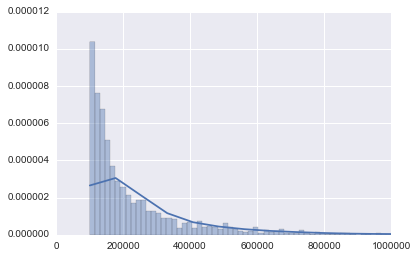

In [6]:
# length of CNVs, and fit mixed geometric distribution
cnv_data = pd.concat([cnvbed_df['delCases'], cnvbed_df['delControls']])
del_length = cnv_data['cnv_end'] - cnv_data['cnv_start']
sns.distplot(del_length, 500)
sns.plt.xlim(0, 1000000)
#sns.distplot(dup_length[0:1000], color="red")
#plt.plot(cnv_length["delControls"])

In [ ]:
# violin plot
import plotly
plotly.offline.init_notebook_mode()
#fig = plotly.figure_factory.create_violin(list(dup_block.values()), colors='#604d9e')
#plotly.offline.iplot(fig, filename='One Violin')

In [7]:
sample_len_del = sample_cnv_length(del_length, env.args['avg_cnv_per_individual'])
#print(sample_len_del)

In [8]:
# Now I get n_del sample CNVs but I only know which block it belongs to
# sample_blocks is just a sample set of `block_counts` removing the `count` part: [(chrom, block_position)]
sample_blocks = get_sample_blocks(block_counts, len(sample_len_del))

In [9]:
# Now for each sample block, I:
# 1. give it a random start position unif(block_start, block_start + block_size)
# 2. give it a random end position using L previously sampled
samples = assign_cnv_to_sample(sample_blocks, sample_len_del, 100000)
# print(samples)

## Step 3

In [10]:
# Annotate data with gene names
samples = annotate_samples(samples, gene_df)
#print(samples)

In [11]:
# get causal genes in data
del_causal_genes_in_sample = get_causal_genes(env.causal_genes["causal_genes_del"][0:50], samples['gene_name'].tolist())
dup_causal_genes_in_sample = get_causal_genes(env.causal_genes["causal_genes_dup"][0:50], samples['gene_name'].tolist())
#print (samples['gene_name'].tolist())
print (len(del_causal_genes_in_sample))

0


## Step 4

In [12]:
#k = 0.005 # prevalence of the disease
#sim_args = {'shape': 2, 'scale': 1}

num_causal_genes_in_sample = len(del_causal_genes_in_sample)
print (num_causal_genes_in_sample)
p = p_case(env.args["prevalence"], num_causal_genes_in_sample, env.args)
print(p)

0
0.005


## Putting all together

In [2]:
# main procedure for duplication
genes = load_reference_gene("data/refGene.txt.gz")
empirical_data = load_cnv_data("data/ISC-r1.CNV.bed")
sample_dup = simulate(genes, pd.concat([empirical_data['dupCases'], empirical_data['dupControls']]), 
                      env.args, env.causal_genes["causal_genes_dup"])
save_data(sample_dup, 'dup_sample_test.pkl')

In [ ]:
# main procedure for deletion
sample_del = simulate(genes, pd.concat([empirical_data['delCases'], empirical_data['delControls']]), 
                      env.args, env.causal_genes["causal_genes_del"])
save_data(sample_del, 'del_sample_test.pkl')

In [4]:
print(sample_del['debug'])

{'niter': 3588, 'number of genes overlap CNV': [4, 2, 48, 24, 17, 7, 4, 0, 2, 13, 8, 71, 2, 59, 6, 40, 8, 19, 0, 55, 23, 25, 19, 20, 18, 10, 24, 12, 9, 40, 17, 7, 1, 4, 18, 5, 7, 28, 12, 4, 40, 23, 6, 34, 70, 2, 13, 39, 9, 6, 7, 22, 11, 18, 25, 14, 21, 108, 22, 74, 43, 16, 11, 9, 15, 30, 21, 15, 11, 6, 20, 9, 7, 18, 18, 37, 1, 23, 47, 8, 18, 7, 16, 37, 12, 6, 10, 9, 1, 10, 8, 5, 11, 11, 26, 18, 19, 7, 13, 14, 43, 16, 16, 5, 10, 5, 32, 26, 10, 23, 4, 6, 8, 10, 10, 21, 21, 19, 51, 24, 13, 17, 7, 20, 25, 45, 70, 14, 18, 5, 16, 12, 17, 41, 12, 16, 16, 23, 5, 24, 19, 19, 12, 5, 39, 2, 16, 13, 4, 18, 4, 15, 17, 0, 25, 11, 9, 37, 12, 13, 13, 0, 39, 31, 12, 5, 6, 10, 9, 22, 9, 36, 18, 6, 40, 19, 1, 32, 26, 14, 10, 14, 12, 11, 9, 31, 25, 17, 21, 4, 11, 20, 26, 1, 25, 12, 15, 16, 6, 23, 10, 43, 13, 13, 2, 3, 9, 7, 27, 11, 15, 16, 26, 3, 1, 21, 0, 6, 28, 8, 8, 11, 19, 47, 28, 32, 36, 51, 6, 22, 6, 34, 11, 64, 22, 14, 25, 21, 18, 18, 23, 11, 26, 17, 8, 29, 3, 16, 20, 8, 10, 21, 7, 7, 7, 16, 12, 27

In [3]:
del_sample = load_data("del_sample_3000.pkl")
#print (del_sample)
dup_sample = load_data("dup_sample_3000.pkl")
#print (del_sample)
#print (del_sample["debug"])

In [ ]:
#block_counts[idx][0] for idx in sample_idx
[pd.concat(del_sample[item]) for item in ["case", "ctrl"]][0]
#for item, value in del_sample.items() for item in ("case", "ctrl"):
#    values = pd.concat(value)
#    print (item)

In [20]:
del_sample_gene = get_gene_table(del_sample)
dup_sample_gene = get_gene_table(dup_sample)

        gene_name  n_case_gene  n_ctrl_gene  n_case_nogene  n_ctrl_nogene
0          ADGRL4          1.0          0.0          172.0          121.0
1          EFCAB2          1.0          0.0          172.0          121.0
2    LOC101928068          1.0          0.0          172.0          121.0
3    LOC102724552          1.0          0.0          172.0          121.0
4            RERE          1.0          0.0          172.0          121.0
5        SNORD128          1.0          0.0          172.0          121.0
6           CELF2          1.0          0.0          172.0          121.0
7       CELF2-AS1          1.0          0.0          172.0          121.0
8       CELF2-AS2          1.0          0.0          172.0          121.0
9       LINC00710          1.0          0.0          172.0          121.0
10           PFKP          1.0          0.0          172.0          121.0
11         PITRM1          1.0          0.0          172.0          121.0
12     PITRM1-AS1          1.0        

In [24]:
del_stats_table = get_stats(del_sample_gene, num=100, sort=0)

In [18]:
dup_stats_table = get_stats(dup_sample_gene, num=100, sort=1)
print (dup_stats_table)

{'top_OR_gene': ['ADAMTSL4', 'ADAMTSL4-AS1', 'DESI2', 'ENSA', 'EYA3', 'FAM76A', 'FGR', 'FOXJ3', 'GUCA2A', 'GUCA2B', 'IFI6', 'MCL1', 'MIR4257', 'PPP1R8', 'RIMKLA', 'RPA2', 'SCARNA1', 'SMPDL3B', 'STX12', 'THEMIS2', 'XKR8', 'ZMYND12', 'ADK', 'AGAP9', 'ANXA8', 'BMS1P6', 'FAM25C', 'FAM25G', 'TMEM72', 'TMEM72-AS1', 'CCDC15', 'ESAM', 'HEPACAM', 'HEPN1', 'LOC100507283', 'LOC101929340', 'MIR7641-2', 'MSANTD2', 'NRGN', 'OR4B1', 'OR4C3', 'OR4C45', 'OR4S1', 'OR4X1', 'OR4X2', 'OR8A1', 'PANX3', 'ROBO3', 'ROBO4', 'SIAE', 'SLC37A2', 'SPA17', 'TBRG1', 'TMEM218', 'VSIG2', 'CAPZA3', 'HELB', 'IRAK3', 'MIR3974', 'MIR4302', 'MIR6502', 'PIK3C2G', 'PLCZ1', 'RASSF8', 'RASSF8-AS1', 'RERGL', 'LOC101927062', 'LOC102724890', 'CDH1', 'CDH3', 'CHTF8', 'HAS3', 'LINC00273', 'LOC100190986', 'MIR3680-2', 'MIR7641-2', 'NPIPB3', 'SLC7A5P2', 'SMG1P3', 'SNTB2', 'SNX29P1', 'TANGO6', 'UTP4', 'ABHD8', 'ANKLE1', 'ANO8', 'BISPR', 'BST2', 'DDA1', 'GTPBP3', 'MRPL34', 'MVB12A', 'PLVAP', 'SGTA', 'THOP1', 'ZNF554', 'ZNF555', 'ZNF556'

In [15]:
print (del_stats_table["top_logp_gene"])

['ADGRL4', 'EFCAB2', 'LOC101928068', 'LOC102724552', 'RERE', 'SNORD128', 'CELF2', 'CELF2-AS1', 'CELF2-AS2', 'LINC00710', 'PFKP', 'PITRM1', 'PITRM1-AS1', 'SFTA1P', 'SLC16A9', 'SNORD142', 'USP6NL', 'ARHGEF17', 'COA4', 'FAM168A', 'LOC283177', 'MRPL48', 'P2RY2', 'P2RY6', 'PAAF1', 'PLEKHB1', 'PPP6R3', 'RAB6A', 'RELT', 'GOLGA8K', 'GOLGA8O', 'ULK4P1', 'ULK4P3', 'WHAMMP1', 'AMFR', 'BBS2', 'DKFZP434H168', 'GNAO1', 'LOC283856', 'MIR3935', 'MT1A', 'MT1B', 'MT1DP', 'MT1E', 'MT1F', 'MT1G', 'MT1H', 'MT1IP', 'MT1JP', 'MT1L', 'MT1M', 'MT2A', 'MT3', 'MT4', 'NUDT21', 'OGFOD1', 'RBFOX1', 'C17orf97', 'FAM27E5', 'FLJ36000', 'LOC105371430', 'MTRNR2L1', 'RFLNB', 'RPH3AL', 'VPS53', 'KIAA1468', 'LOC100505853', 'PHLPP1', 'TNFRSF11A', 'ZCCHC2', 'AKAP8L', 'CYP4F12', 'CYP4F22', 'CYP4F3', 'CYP4F8', 'MIR1470', 'PGLYRP2', 'RASAL3', 'WIZ', 'ANKRD36', 'ANKRD36B', 'EN1', 'FAHD2B', 'LCT', 'LOC100506076', 'LOC100506123', 'LOC105373782', 'MARCO', 'R3HDM1', 'THSD7B', 'UBXN4', 'FRG1BP', 'FRG1DP', 'LINC01598', 'MLLT10P1', 'RA

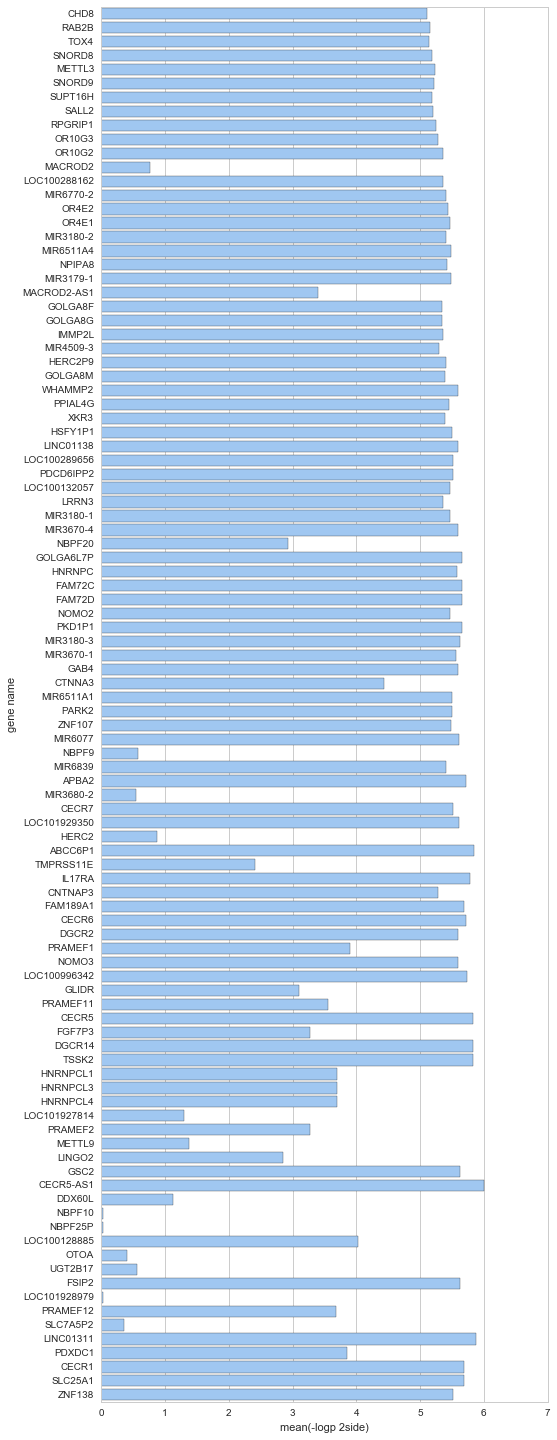

In [48]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize=(8, 25))
p_df = pd.DataFrame({"-logp 2side": del_stats_table["top_logp_2side"], 
                     "gene name": del_stats_table["top_logp_gene"]})
plot = sns.barplot(x="-logp 2side", y="gene name", data=p_df, color="b")
#print (plot)

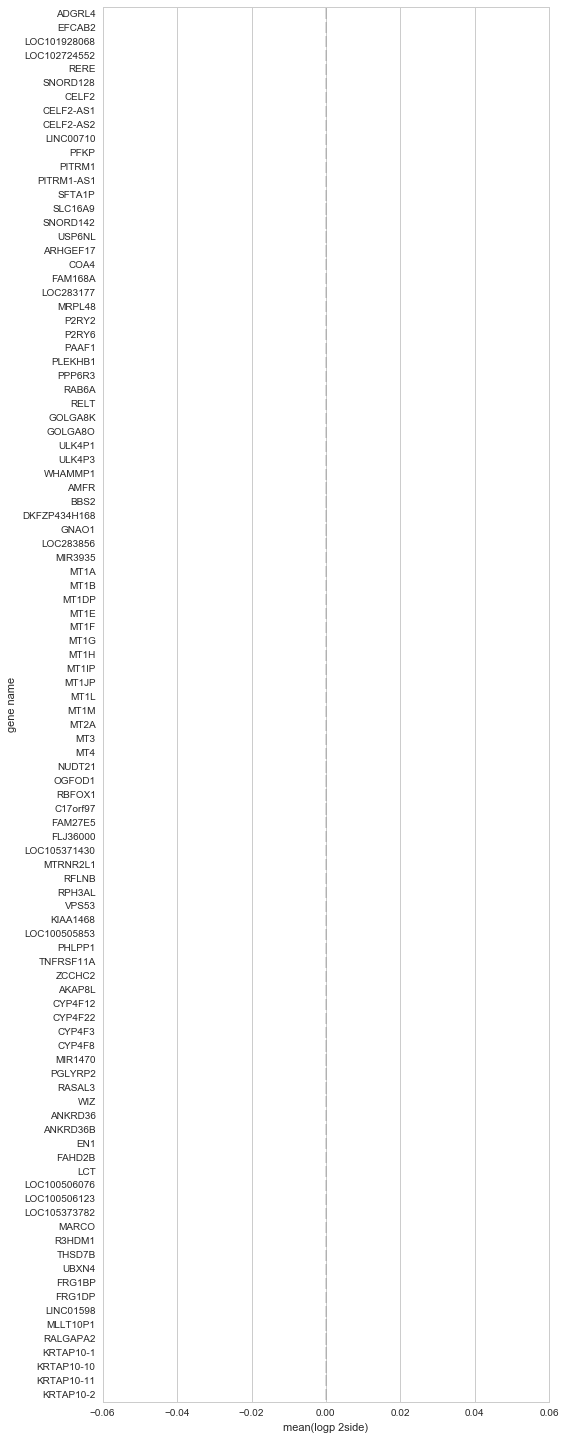

In [16]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize=(8, 25))
p_df = pd.DataFrame({"logp 2side": dup_stats_table["top_logp_2side"], "gene name":dup_stats_table["top_logp_gene"]})
plot = sns.barplot(x="logp 2side", y="gene name", data=p_df, color="r")

# Export all functions to script


In [49]:
! jupyter nbconvert --to script simulation.ipynb
! python extract_function.py --from simulation.py --to simulation.py

[NbConvertApp] Converting notebook simulation.ipynb to script
[NbConvertApp] Writing 24370 bytes to simulation.py
